# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase2_all_20220130.csv')

## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
WF_poly1 = Polygon([(10.0, 12.9), (10.0, 8.3), (11.3, 8.3), (11.3, 12.9)])

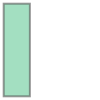

In [ ]:
WF_poly1

In [ ]:
WF_poly2 = Polygon([(9.6, 17.6), (9.6, 14.3), (10.9, 14.3), (10.9, 17.6)])

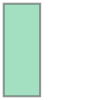

In [ ]:
WF_poly2

In [ ]:
WF_poly3 = Polygon([(12.2, 17.6), (12.2, 16.2), (15.3, 16.2), (15.3, 17.6)])

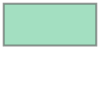

In [ ]:
WF_poly3

## MultiPolygon Creation

In this example there are two separate sections for the machines. So multiple polygons must be created and subsequently combined to create a MultiPolygon.

In [ ]:
WF_multipoly = MultiPolygon([WF_poly1, WF_poly2, WF_poly3])

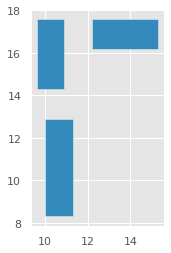

In [ ]:
 p = gpd.GeoSeries(WF_multipoly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
WF_multipoly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(WF_multipoly))

In [ ]:
WF_multipoly_gdf

,geometry
0,"MULTIPOLYGON (((10.00000 12.90000, 10.00000 8...."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
AF_join = gpd.sjoin(gdf, WF_multipoly_gdf, how = 'inner')
AF_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
108,G1221,"11.019,12.364",30/11/2021 11:11,30/11/2021 11:15,11.019,12.364,POINT (11.01900 12.36400),0
358,G1223,"10.824,9.077",30/11/2021 11:28,30/11/2021 11:30,10.824,9.077,POINT (10.82400 9.07700),0
360,G1223,"11.024,9.077",30/11/2021 11:30,30/11/2021 11:32,11.024,9.077,POINT (11.02400 9.07700),0
362,G1223,"10.824,9.077",30/11/2021 11:32,30/11/2021 11:33,10.824,9.077,POINT (10.82400 9.07700),0
364,G1223,"10.824,9.077",30/11/2021 11:33,30/11/2021 11:35,10.824,9.077,POINT (10.82400 9.07700),0
...,...,...,...,...,...,...,...,...
105741,R4000,"10.661,15.585",20/12/2021 12:03,20/12/2021 12:03,10.661,15.585,POINT (10.66100 15.58500),0
105743,R4000,"10.661,15.585",20/12/2021 12:03,20/12/2021 12:03,10.661,15.585,POINT (10.66100 15.58500),0
105745,R4000,"10.661,15.585",20/12/2021 12:03,20/12/2021 12:03,10.661,15.585,POINT (10.66100 15.58500),0
105747,R4000,"10.661,15.585",20/12/2021 12:03,20/12/2021 12:03,10.661,15.585,POINT (10.66100 15.58500),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
AF_join['newfrom'] = lookup(AF_join['from'], format='%d/%m/%Y %H:%M')
AF_join['newto'] = lookup(AF_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = AF_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00
...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:29:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal
...,...,...,...,...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:29:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          505
mean     0 days 00:08:10.930693069
std      0 days 00:20:36.357667863
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:04:00
75%                0 days 00:07:00
max                0 days 04:29:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal,Friday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal,Friday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon      0 days 00:07:48.900000
morning     0 days 00:08:25.377049180
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:04:45.714285714
Tuesday,0 days 00:06:33.277310924
Wednesday,0 days 00:09:12.656250
Thursday,0 days 00:09:53.949579831
Friday,0 days 00:09:08.684210526
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
63
Tuesday
119
Wednesday
128
Thursday
119
Friday
76
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday,morning,11
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday,morning,10
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday,morning,11
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11
...,...,...,...,...,...,...,...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday,morning,10
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday,morning,10
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday,morning,10
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal,Friday,morning,10


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:23:13.636363636
11   0 days 00:06:21.068702290
12      0 days 00:05:07.500000
13             0 days 00:07:00
14      0 days 00:08:47.200000
15   0 days 00:08:15.348837209
16   0 days 00:04:53.513513513
17             0 days 00:06:30
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
44
Eleven
131
Twelve
104
One
26
Two
75
Three
86
Four
37


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:06:07.443609022
R   0 days 00:10:28.368200836
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
266
Medical Retinal
239


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday,morning,11,G,4.0000
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday,morning,10,G,7.0000
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday,morning,11,G,8.0000
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday,morning,10,R,180.0000
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday,morning,10,R,21.0000
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal,Friday,morning,10,R,269.0000


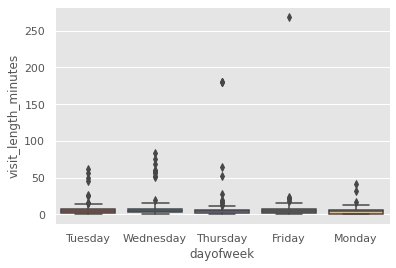

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

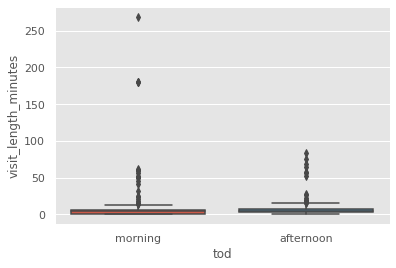

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

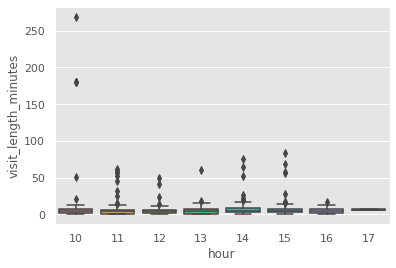

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

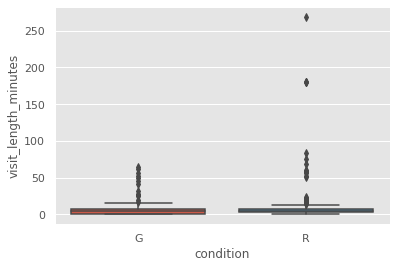

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 431
newfrom                 431
newto                   431
visit_length            431
start_day               431
end_day                 431
sameday                 431
dayofweek               431
tod                     431
hour                    431
condition               431
visit_length_minutes    431
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday,morning,11,G,4.0000
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday,morning,10,G,7.0000
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday,morning,11,G,8.0000
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
496,R1254,2022-01-27 10:42:00,2022-01-27 10:45:00,0 days 00:03:00,27,27,equal,Thursday,morning,10,R,3.0000
498,R1301,2022-01-27 10:38:00,2022-01-27 10:47:00,0 days 00:09:00,27,27,equal,Thursday,morning,10,R,9.0000
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday,morning,10,R,21.0000
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

6.338677354709419
7.733496332518337


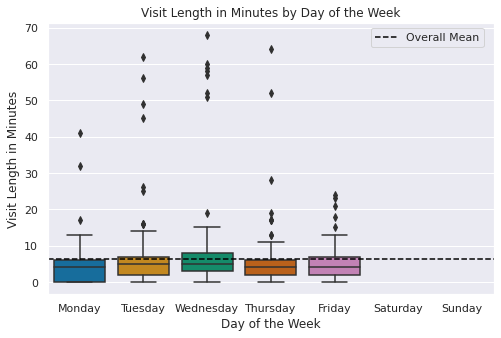

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

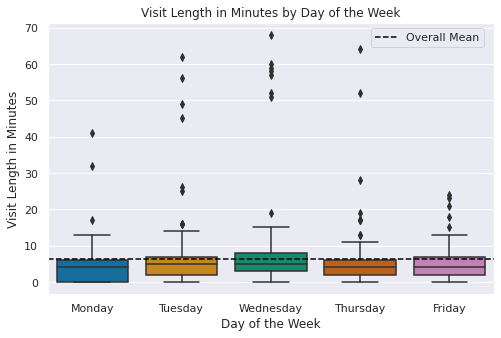

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

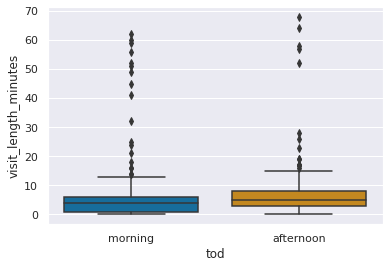

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

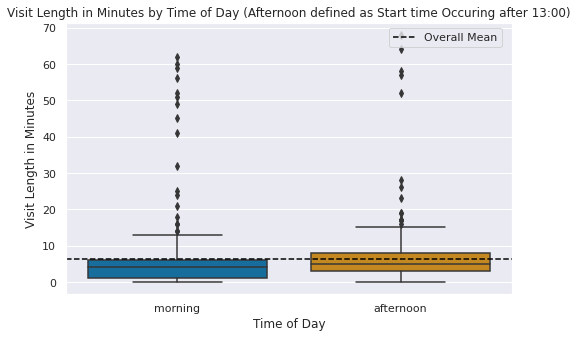

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

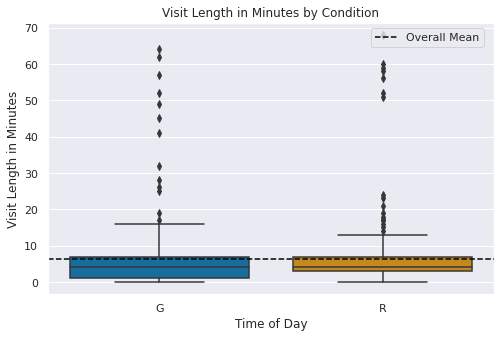

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

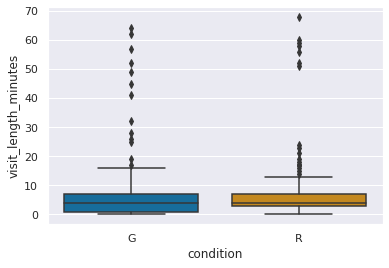

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

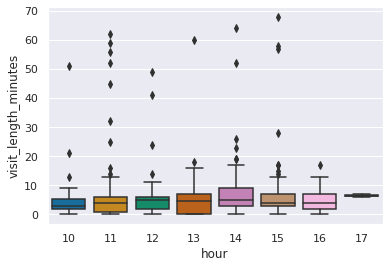

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

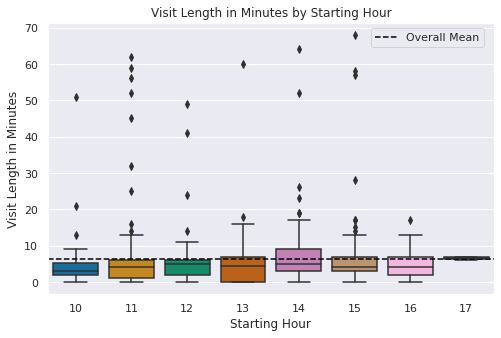

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   499.0000
mean                                      6.3387
std                                       9.5446
min                                       0.0000
25%                                       2.0000
50%                                       4.0000
75%                                       7.0000
max                                      68.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   505.0000
mean                                      8.1822
std                                      20.6060
min                                       0.0000
25%                                       2.0000
50%                                       4.0000
75%                                       7.0000
max                                     269.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

4.0

In [ ]:
df_outliers['visit_length'].describe()

count                          499
mean     0 days 00:06:20.320641282
std      0 days 00:09:32.677689752
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:04:00
75%                0 days 00:07:00
max                0 days 01:08:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          505
mean     0 days 00:08:10.930693069
std      0 days 00:20:36.357667863
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:04:00
75%                0 days 00:07:00
max                0 days 04:29:00
Name: visit_length, dtype: object

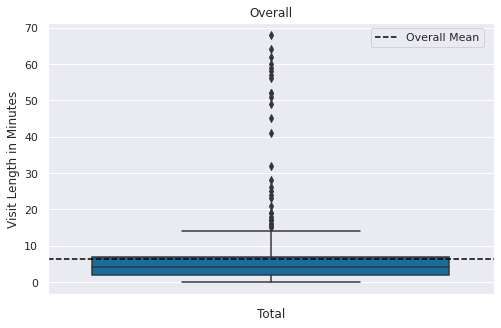

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
40
Eleven
131
Twelve
104
One
26
Two
74
Three
85
Four
37


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
63
Tuesday Outlier
119
Wednesday Outlier
126
Thursday Outlier
116
Friday Outlier
75
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                        4.7619
Tuesday                                       6.5546
Wednesday                                     8.0873
Thursday                                      5.5000
Friday                                        5.6800
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
266
R
233


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                     6.1241
R                                     6.5837
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
301
afternoon
198


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                     7.0859
morning                                       5.8472
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
40
Eleven
131
Twelve
104
One
26
Two
74
Three
85
Four
37


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                     5.3250
11                                     6.3511
12                                     5.1250
13                                     7.0000
14                                     7.8784
15                                     7.3647
16                                     4.8919
17                                     6.5000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 431
newfrom                 431
newto                   431
visit_length            431
start_day               431
end_day                 431
sameday                 431
dayofweek               431
tod                     431
hour                    431
condition               431
visit_length_minutes    431
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 90
newfrom                 90
newto                   90
visit_length            90
start_day               90
end_day                 90
sameday                 90
dayofweek               90
tod                     90
hour                    90
condition               90
visit_length_minutes    90
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 409
newfrom                 409
newto                   409
visit_length            409
start_day               409
end_day                 409
sameday                 409
dayofweek               409
tod                     409
hour                    409
condition               409
visit_length_minutes    409
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
23,G1248,2021-12-01 11:02:00,2021-12-01 11:02:00,0 days,1,1,equal,Wednesday,morning,11,G,0.0000
34,G1263,2021-12-02 11:49:00,2021-12-02 11:49:00,0 days,2,2,equal,Thursday,morning,11,G,0.0000
35,G1265,2021-12-02 12:09:00,2021-12-02 12:09:00,0 days,2,2,equal,Thursday,morning,12,G,0.0000
62,G1338,2021-12-06 11:34:00,2021-12-06 11:34:00,0 days,6,6,equal,Monday,morning,11,G,0.0000
63,G1340,2021-12-06 11:34:00,2021-12-06 11:34:00,0 days,6,6,equal,Monday,morning,11,G,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
23,G1248,2021-12-01 11:02:00,2021-12-01 11:02:00,0 days,1,1,equal,Wednesday,morning,11,G,0.0000
34,G1263,2021-12-02 11:49:00,2021-12-02 11:49:00,0 days,2,2,equal,Thursday,morning,11,G,0.0000
35,G1265,2021-12-02 12:09:00,2021-12-02 12:09:00,0 days,2,2,equal,Thursday,morning,12,G,0.0000
62,G1338,2021-12-06 11:34:00,2021-12-06 11:34:00,0 days,6,6,equal,Monday,morning,11,G,0.0000
63,G1340,2021-12-06 11:34:00,2021-12-06 11:34:00,0 days,6,6,equal,Monday,morning,11,G,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
285,R0888,2021-12-01 15:18:00,2021-12-01 16:26:00,0 days 01:08:00,1,1,equal,Wednesday,afternoon,15,R,68.0000
152,G1589,2022-01-06 14:35:00,2022-01-06 15:39:00,0 days 01:04:00,6,6,equal,Thursday,afternoon,14,G,64.0000
8,G1231,2021-11-30 11:49:00,2021-11-30 12:51:00,0 days 01:02:00,30,30,equal,Tuesday,morning,11,G,62.0000
279,R0881,2021-12-01 13:42:00,2021-12-01 14:42:00,0 days 01:00:00,1,1,equal,Wednesday,morning,13,R,60.0000
445,R1175,2022-01-19 11:09:00,2022-01-19 12:08:00,0 days 00:59:00,19,19,equal,Wednesday,morning,11,R,59.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
285,R0888,2021-12-01 15:18:00,2021-12-01 16:26:00,0 days 01:08:00,1,1,equal,Wednesday,afternoon,15,R,68.0000
152,G1589,2022-01-06 14:35:00,2022-01-06 15:39:00,0 days 01:04:00,6,6,equal,Thursday,afternoon,14,G,64.0000
8,G1231,2021-11-30 11:49:00,2021-11-30 12:51:00,0 days 01:02:00,30,30,equal,Tuesday,morning,11,G,62.0000
279,R0881,2021-12-01 13:42:00,2021-12-01 14:42:00,0 days 01:00:00,1,1,equal,Wednesday,morning,13,R,60.0000
445,R1175,2022-01-19 11:09:00,2022-01-19 12:08:00,0 days 00:59:00,19,19,equal,Wednesday,morning,11,R,59.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
503,R1306,2022-01-28 10:13:00,2022-01-28 14:42:00,0 days 04:29:00,28,28,equal,Friday,morning,10,R,269.0000
497,R1300,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday,morning,10,R,180.0000
499,R1302,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday,morning,10,R,180.0000
500,R1303,2022-01-27 10:38:00,2022-01-27 13:38:00,0 days 03:00:00,27,27,equal,Thursday,morning,10,R,180.0000
284,R0887,2021-12-01 15:11:00,2021-12-01 16:35:00,0 days 01:24:00,1,1,equal,Wednesday,afternoon,15,R,84.0000
385,R1061,2022-01-05 14:16:00,2022-01-05 15:32:00,0 days 01:16:00,5,5,equal,Wednesday,afternoon,14,R,76.0000
285,R0888,2021-12-01 15:18:00,2021-12-01 16:26:00,0 days 01:08:00,1,1,equal,Wednesday,afternoon,15,R,68.0000
152,G1589,2022-01-06 14:35:00,2022-01-06 15:39:00,0 days 01:04:00,6,6,equal,Thursday,afternoon,14,G,64.0000
8,G1231,2021-11-30 11:49:00,2021-11-30 12:51:00,0 days 01:02:00,30,30,equal,Tuesday,morning,11,G,62.0000
279,R0881,2021-12-01 13:42:00,2021-12-01 14:42:00,0 days 01:00:00,1,1,equal,Wednesday,morning,13,R,60.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
285,R0888,2021-12-01 15:18:00,2021-12-01 16:26:00,0 days 01:08:00,1,1,equal,Wednesday,afternoon,15,R,68.0000
152,G1589,2022-01-06 14:35:00,2022-01-06 15:39:00,0 days 01:04:00,6,6,equal,Thursday,afternoon,14,G,64.0000
8,G1231,2021-11-30 11:49:00,2021-11-30 12:51:00,0 days 01:02:00,30,30,equal,Tuesday,morning,11,G,62.0000
279,R0881,2021-12-01 13:42:00,2021-12-01 14:42:00,0 days 01:00:00,1,1,equal,Wednesday,morning,13,R,60.0000
445,R1175,2022-01-19 11:09:00,2022-01-19 12:08:00,0 days 00:59:00,19,19,equal,Wednesday,morning,11,R,59.0000
415,R1117,2022-01-12 15:30:00,2022-01-12 16:28:00,0 days 00:58:00,12,12,equal,Wednesday,afternoon,15,R,58.0000
33,G1261,2021-12-01 15:45:00,2021-12-01 16:42:00,0 days 00:57:00,1,1,equal,Wednesday,afternoon,15,G,57.0000
442,R1169,2022-01-18 11:40:00,2022-01-18 12:36:00,0 days 00:56:00,18,18,equal,Tuesday,morning,11,R,56.0000
31,G1257,2021-12-01 14:29:00,2021-12-01 15:21:00,0 days 00:52:00,1,1,equal,Wednesday,afternoon,14,G,52.0000
458,R1192,2022-01-20 11:16:00,2022-01-20 12:08:00,0 days 00:52:00,20,20,equal,Thursday,morning,11,R,52.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 11:11:00,2021-11-30 11:15:00,0 days 00:04:00,30,30,equal,Tuesday,morning,11,G,4.0000
1,G1223,2021-11-30 11:28:00,2021-11-30 11:35:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
2,G1224,2021-11-30 10:59:00,2021-11-30 11:06:00,0 days 00:07:00,30,30,equal,Tuesday,morning,10,G,7.0000
3,G1225,2021-11-30 11:23:00,2021-11-30 11:31:00,0 days 00:08:00,30,30,equal,Tuesday,morning,11,G,8.0000
4,G1227,2021-11-30 11:19:00,2021-11-30 11:26:00,0 days 00:07:00,30,30,equal,Tuesday,morning,11,G,7.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
496,R1254,2022-01-27 10:42:00,2022-01-27 10:45:00,0 days 00:03:00,27,27,equal,Thursday,morning,10,R,3.0000
498,R1301,2022-01-27 10:38:00,2022-01-27 10:47:00,0 days 00:09:00,27,27,equal,Thursday,morning,10,R,9.0000
501,R1304,2022-01-28 10:13:00,2022-01-28 10:34:00,0 days 00:21:00,28,28,equal,Friday,morning,10,R,21.0000
502,R1305,2022-01-28 10:33:00,2022-01-28 10:34:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
250,G1846,2022-01-26 17:09:00,2022-01-26 17:15:00,0 days 00:06:00,26,26,equal,Wednesday,afternoon,17,G,6.0000


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'WF'
WFdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
WFdf.to_csv('WFdf.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
